https://towardsdatascience.com/classify-toxic-online-comments-with-lstm-and-glove-e455a58da9c7

tensorflow-macos==2.8.0

tensorflow-metal==0.4.0

Keras==2.8.0

tensorflow-hub==0.12.0

In [1]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
from tqdm import tqdm_notebook
import numpy as np
from nltk.corpus import stopwords
import pandas as pd
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "../glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

train = pd.read_csv('../data/train_wikipedia_clean.csv')
test = pd.read_csv('../data/test_wikipedia_clean.csv')
test = test.loc[test.toxic !=-1]


#print(train.head())
train = train[['comment_text', 'toxic']]
labels = ['toxic']
y = train[labels].values
comments_train = train['comment_text']
comments_train = list(comments_train)
x_test = test['comment_text']
y_test = test['toxic']

In [ ]:
texts = comments_train

In [ ]:
print('Sample data:', texts[1], y[1])


Sample data: Daww He matches this background colour I am seemingly stuck with Thanks talk January UTC [0]


In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token=1)
tokenizer.fit_on_texts(texts + list(x_test))
sequences = tokenizer.texts_to_sequences(texts)
sequences_test = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 287319


In [ ]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(sequences_test, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (223113, 200)
Shape of label tensor: (223113, 1)


Shuffle the data.


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

Create the train-validation split.



In [ ]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [17052]
validation:  [4332]


In [ ]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 1344   653  4791     8  3613  1798    14  3061   216    34     2 17226
  2890   148     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [ ]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: ../glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-12 11:02:09.239277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 11:02:09.239877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
import tensorflow as tf
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = [tf.keras.metrics.AUC()]) #tf.keras.metrics.AUC()

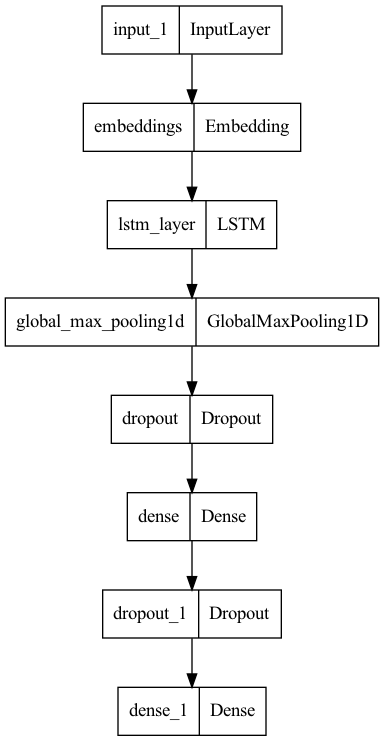

In [ ]:

tf.keras.utils.plot_model(model)


In [ ]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/2


2022-05-12 11:02:10.361984: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 11:02:11.206165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 11:02:11.526990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 11:02:11.920302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5578/5578 [==============================] - ETA: 0s - loss: 0.1442 - auc: 0.9506

2022-05-12 11:05:33.825196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 11:05:33.929060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5578/5578 [==============================] - 231s 41ms/step - loss: 0.1442 - auc: 0.9506 - val_loss: 0.1259 - val_auc: 0.9665
Epoch 2/2
5578/5578 [==============================] - 232s 42ms/step - loss: 0.1214 - auc: 0.9665 - val_loss: 0.1187 - val_auc: 0.9688


Evaluating the model

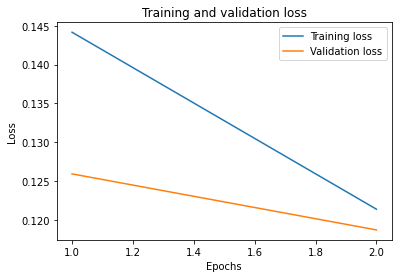

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
history.history

{'loss': [0.14417210221290588, 0.12135380506515503],
 'auc': [0.9506429433822632, 0.9664648771286011],
 'val_loss': [0.12590637803077698, 0.11868041008710861],
 'val_auc': [0.9664591550827026, 0.9687933921813965]}

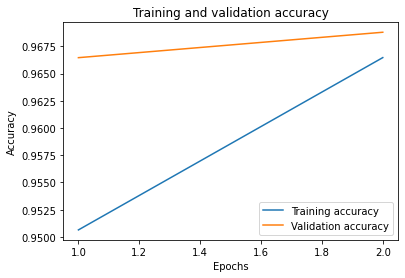

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
plt.plot(epochs, auc, label='Training accuracy')
plt.plot(epochs, val_auc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

Test performance

In [ ]:
model.evaluate(data_test, y_test)

1987/1987 [==============================] - 44s 22ms/step - loss: 0.1348 - auc: 0.9657


[0.13476547598838806, 0.9656551480293274]

In [ ]:
y_hat = model.predict(data_test)


2022-05-12 11:10:38.002279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-12 11:10:38.050287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test Predictions

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score

for p in np.linspace(0.1, 0.9, num=19):
    print(p)
    df_evaluation = pd.DataFrame(data = test['id'], columns = ['id'])
    t = y_hat>p
    df_evaluation['predictions'] = t.astype(int)
    df_evaluation['y'] = y_test
    results = pd.DataFrame({'id': df_evaluation.id})
    #results.to_csv('result.csv', index=False)
    results = pd.merge(results, df_evaluation, on='id')
    #print(precision_score(results.y,results.predictions))
    print(roc_auc_score(results.y,results.predictions))

0.1
0.9024812023760028
0.14444444444444446
0.9065378775198236
0.18888888888888888
0.9046822627101816
0.23333333333333334
0.9022335170949939
0.2777777777777778
0.8960467545338975
0.32222222222222224
0.8905103270693584
0.3666666666666667
0.8797324627002225
0.4111111111111111
0.8680237912256357
0.4555555555555556
0.8535900117168307
0.5
0.8414594623456579
0.5444444444444445
0.8282534603046615
0.5888888888888889
0.8152307099751445
0.6333333333333333
0.8000673432791408
0.6777777777777778
0.7834348432026484
0.7222222222222222
0.7643517976905905
0.7666666666666667
0.7455814109751847
0.8111111111111111
0.7220143229705676
0.8555555555555555
0.6943633525374168
0.9
0.6610201801860175


In [ ]:
df_evaluation = pd.DataFrame(data = test['id'], columns = ['id'])
t = y_hat>=0.8
df_evaluation['predictions'] = t.astype(int)
df_evaluation['y'] = y_test
results = pd.DataFrame({'id': df_evaluation.id})
#results.to_csv('result.csv', index=False)
results = pd.merge(results, df_evaluation, on='id')
print(precision_score(results.y,results.predictions))

0.8617441507140686


In [ ]:
print(sum((results.y ==1)& (results.predictions == 1))/len(results)) # true_toxic 
print(sum((results.y ==0)& (results.predictions == 0))/len(results)) # true_nottoxic
print(sum((results.y ==0)& (results.predictions == 1))/len(results)) # false alarm
print(sum((results.y ==1)& (results.predictions == 0))/len(results)) # misses

#sum((results.y ==1)& (results.predictions == 0))


0.044614343920587725
0.8970377711705759
0.007157802004184561
0.05119008290465178


Confusion matrix, without normalization
[[57022   455]
 [ 3254  2836]]


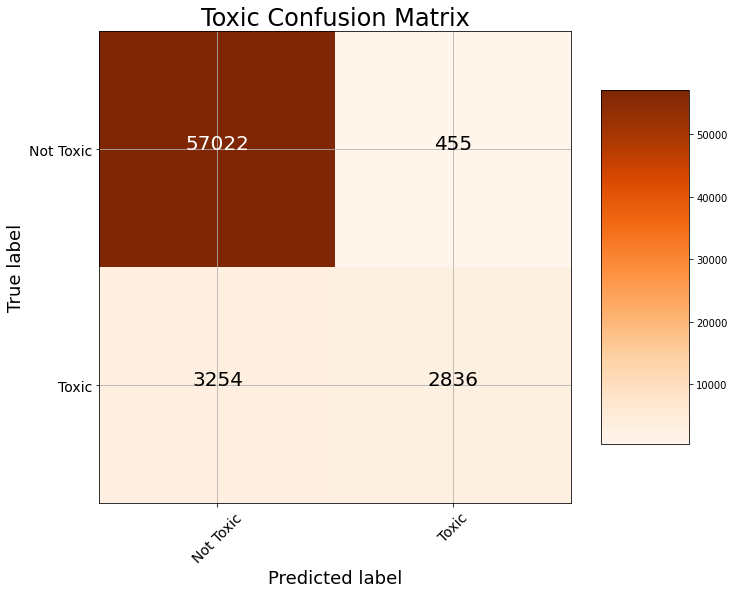

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(results.y, results.predictions, )

plot_confusion_matrix(cm, classes = ['Not Toxic', 'Toxic'],
                      title = 'Toxic Confusion Matrix', normalize=False)


Predict new comment

save tokenizer
save model

In [ ]:
import pickle
# saving
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

2022-05-12 11:11:13.787670: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://af93c882-fad0-42c4-81ec-e1e2fa008b06/assets


INFO:tensorflow:Assets written to: ram://af93c882-fad0-42c4-81ec-e1e2fa008b06/assets


In [ ]:
text = 'your mother'
# preprocess
sequences_y = tokenizer.texts_to_sequences([text])
data_y = pad_sequences(sequences_y, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)


NameError: name 'tokenizer' is not defined

In [ ]:
data_y.shape

(1, 200)

In [ ]:
y_hat = model.predict(data_y)


In [ ]:
y_hat[0][0]>=0.8

False